**Data Wrangling**


## PCA Code

In [10]:
# import packages
import numpy as np
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn.preprocessing import normalize
import pandas as pd
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# RGB Version of PCA

The following code wrangles the images, turning them into arrays, and loads them in as a dataset, simpsons_rgb, so that we can work with it in our project.

In [2]:
# import dataset

# import additional packages to process images as dataset
import os
from PIL import Image

# wrangle images and transform into arrays
def load_images_from_folder(folder_path, target_size=(75, 75), color_mode='RGB'):
    images = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Load image
            img = Image.open(file_path).convert(color_mode)  # Convert to color space
            img = img.resize(target_size)  # Resize to target size
            images.append(np.array(img).flatten())  # Flatten to 1D array
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images)


In [3]:
# Normalize and treat each RGB channel seperately 
def normalize_channels(images):
    n_samples, flattened_size = images.shape # Assigns dimensions of images to n_samples and flattened_size
    side_length = int(np.sqrt(flattened_size // 3)) # finds side length based on flattened image
    images_reshaped = images.reshape((n_samples, side_length, side_length, 3)) # reshapes images to sample size, side length, 3 (3 channels)

    # Extract height & width of reshaped version
    height, width = images_reshaped.shape[1], images_reshaped.shape[2]


    # Split into R, G, B channels
    r_channel = images_reshaped[..., 0]
    g_channel = images_reshaped[..., 1]
    b_channel = images_reshaped[..., 2]

    # Individually normalize (make between 0-1) each channel
    r_channel = r_channel / 255.0
    g_channel = g_channel / 255.0
    b_channel = b_channel / 255.0

    return r_channel, g_channel, b_channel, height, width

In [4]:
# Perform PCA on each channel separately

from sklearn.decomposition import PCA

def perform_pca_on_channel(channel_data, n_components):
    # Similar to flattening an array, flatten each channel for PCA
    n_samples, height, width = channel_data.shape # get dimensions of channel data
    channel_flattened = channel_data.reshape((n_samples, height*width)) # flatten based on channel dimensions
    
    # compute mean
    channel_mean = np.mean(channel_flattened, axis=0)
    # subtract the mean from the flattened dataset
    channel_centered = channel_flattened - channel_mean

    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(channel_centered) # our transformed data matrix / diagonal matrix of standard deviation
    principal_components = pca.components_

    return Z, principal_components, channel_mean


In [5]:
# Reconstruct images by each channel

# First reconstruct each channel individually
def reconstruct_channel(Z, principal_components, channel_mean, height, width):
    # dot product of eigenvectors and Z-hat, then add mean
    reconstructed_flattened = np.dot(Z, principal_components) + channel_mean

    # Convert from flattened channel back to dimensional image
    reconstructed_channel = reconstructed_flattened.reshape((-1, height, width))

    return reconstructed_channel

# combine channels
def combine_channels(r, g, b):
    reconstruct_rgb = np.stack((r, g, b), axis=1).transpose(0, 2, 3, 1)

    return reconstruct_rgb


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 74.5, 74.5, -0.5)

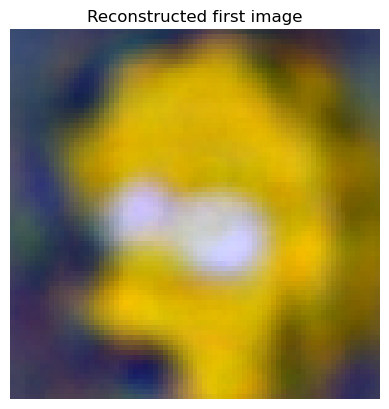

In [6]:
# Load dataset
folder_path = "simpsons_faces_kostastokis/cropped"
simpsons_rgb = load_images_from_folder(folder_path, target_size=(75,75))

# Combine all our functions

# Extract & normalize the RGB channels from the simpson_rgb datase, by applying our normalize_channels function
r_channel, g_channel, b_channel, height, width = normalize_channels(simpsons_rgb)

# initialize how many components we want to use
n_components = 75
# Perform PCA on each channel, applying our perform_pca_on_channel function
r_Z, r_principal_components, r_channel_mean = perform_pca_on_channel(r_channel, n_components)
g_Z, g_principal_components, g_channel_mean = perform_pca_on_channel(g_channel, n_components)
b_Z, b_principal_components, b_channel_mean = perform_pca_on_channel(b_channel, n_components)

# Reconstruct each channel using our function
r_reconstructed = reconstruct_channel(r_Z, r_principal_components, r_channel_mean, height, width)
g_reconstructed = reconstruct_channel(g_Z, g_principal_components, g_channel_mean, height, width)
b_reconstructed = reconstruct_channel(b_Z, b_principal_components, b_channel_mean, height, width)

# Combine channels
reconstructed_rgb = combine_channels(r_reconstructed, g_reconstructed, b_reconstructed)

# Test reconstructing an image
plt.imshow(reconstructed_rgb[0])
plt.title("Reconstructed first image")
plt.axis('off')


In [7]:
print(f"r_reconstructed shape: {r_reconstructed.shape}")
print(f"g_reconstructed shape: {g_reconstructed.shape}")
print(f"b_reconstructed shape: {b_reconstructed.shape}")

print(f"Dataset shape: {simpsons_rgb.shape}")

r_reconstructed shape: (9877, 75, 75)
g_reconstructed shape: (9877, 75, 75)
b_reconstructed shape: (9877, 75, 75)
Dataset shape: (9877, 16875)


### had to edit the code above to make it work for clustering

In [11]:
def load_images_from_folder(folder_path, target_size=(75, 75), color_mode='RGB'):
    images = []
    original_images = []  
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert(color_mode)  
            img_resized = img.resize(target_size)  
            images.append(np.array(img_resized).flatten())  
            original_images.append(np.array(img_resized)) 
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(original_images) 


In [12]:
def normalize_channels(images):
    n_samples, flattened_size = images.shape 
    side_length = int(np.sqrt(flattened_size // 3))  
    images_reshaped = images.reshape((n_samples, side_length, side_length, 3)) 
    
    height, width = images_reshaped.shape[1], images_reshaped.shape[2]

    r_channel = images_reshaped[..., 0]
    g_channel = images_reshaped[..., 1]
    b_channel = images_reshaped[..., 2]

    r_channel = r_channel / 255.0
    g_channel = g_channel / 255.0
    b_channel = b_channel / 255.0

    return r_channel, g_channel, b_channel, height, width


In [13]:
def perform_pca_on_channel(channel_data, n_components):
    n_samples, height, width = channel_data.shape 
    channel_flattened = channel_data.reshape((n_samples, height*width))  
    
    channel_mean = np.mean(channel_flattened, axis=0)
    channel_centered = channel_flattened - channel_mean

    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(channel_centered) 
    principal_components = pca.components_

    return Z, principal_components, channel_mean


In [14]:
def reconstruct_channel(Z, principal_components, channel_mean, height, width):
    reconstructed_flattened = np.dot(Z, principal_components) + channel_mean

    reconstructed_channel = reconstructed_flattened.reshape((-1, height, width))

    return reconstructed_channel


In [15]:
def combine_channels(r, g, b):
    reconstruct_rgb = np.stack((r, g, b), axis=1).transpose(0, 2, 3, 1)

    return reconstruct_rgb


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 74.5, 74.5, -0.5)

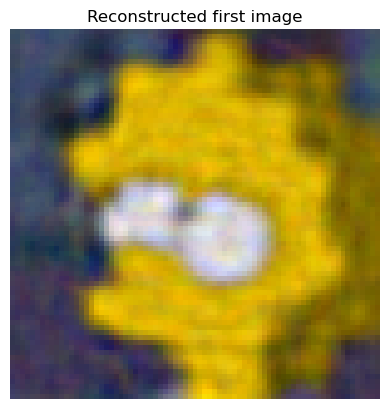

In [63]:
folder_path = "simpsons_faces_kostastokis/cropped"
simpsons_rgb, simpsons_original_rgb = load_images_from_folder(folder_path, target_size=(75, 75))

r_channel, g_channel, b_channel, height, width = normalize_channels(simpsons_rgb)

n_components = 300 #(make bigger for shraper image, but it will run slower)

r_Z, r_principal_components, r_channel_mean = perform_pca_on_channel(r_channel, n_components)
g_Z, g_principal_components, g_channel_mean = perform_pca_on_channel(g_channel, n_components)
b_Z, b_principal_components, b_channel_mean = perform_pca_on_channel(b_channel, n_components)

r_reconstructed = reconstruct_channel(r_Z, r_principal_components, r_channel_mean, height, width)
g_reconstructed = reconstruct_channel(g_Z, g_principal_components, g_channel_mean, height, width)
b_reconstructed = reconstruct_channel(b_Z, b_principal_components, b_channel_mean, height, width)

reconstructed_rgb = combine_channels(r_reconstructed, g_reconstructed, b_reconstructed)

plt.imshow(reconstructed_rgb[0])
plt.title("Reconstructed first image")
plt.axis('off')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


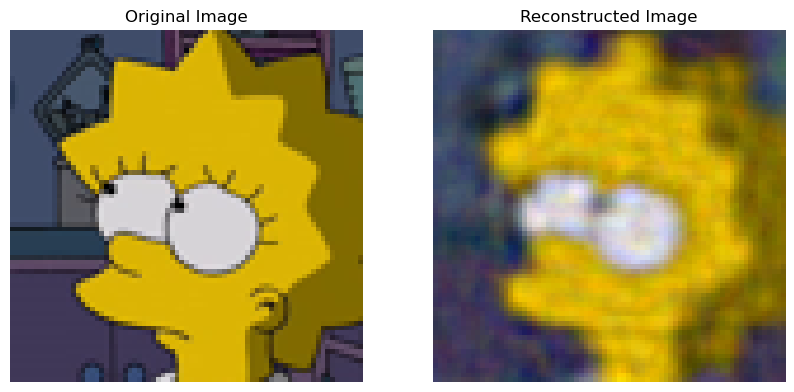

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(simpsons_original_rgb[0])
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(reconstructed_rgb[0])
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')
plt.show()


In [103]:
def combine_channels_for_clustering(r_Z, g_Z, b_Z, top_k):
    r_Z_top = r_Z[:, :top_k]
    g_Z_top = g_Z[:, :top_k]
    b_Z_top = b_Z[:, :top_k]
    
    combined_data = np.hstack((r_Z_top, g_Z_top, b_Z_top))
    return combined_data

top_k = 4
combined_Z = combine_channels_for_clustering(r_Z, g_Z, b_Z, top_k)
print(f"Combined PCA feature matrix shape (after top components): {combined_Z.shape}")


Combined PCA feature matrix shape (after top components): (9877, 12)


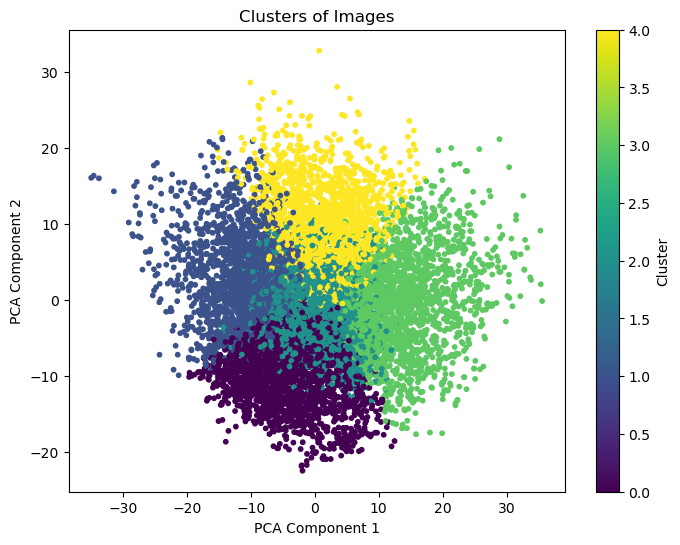

[[ 6.24703697e-01 -4.33782954e-02 -7.36961791e-05 -4.14777793e-04
   6.21709708e-01 -3.74393085e-02 -1.06501790e-02 -1.86271940e-02
  -4.04697789e-01  2.33736382e-01  1.57868409e-02  2.85683984e-02]
 [ 4.04442724e-01  3.22783179e-01  3.17900486e-02  1.72253137e-02
   7.98187780e-02  3.19656745e-01  2.49124169e-02  5.96681969e-02
   7.69962768e-01  1.55219172e-01 -2.33359505e-02  2.67799668e-02]]


In [110]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(combined_Z)

pca_2d = PCA(n_components=2)
combined_Z_2d = pca_2d.fit_transform(combined_Z)

plt.figure(figsize=(8, 6))
plt.scatter(combined_Z_2d[:, 0], combined_Z_2d[:, 1], c=clusters, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title('Clusters of Images')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

top_components = pca_2d.components_

print(top_components)


In [105]:
def plot_images_from_cluster(cluster_idx, images, labels, target_size=(75, 75)):
    cluster_images_idx = np.where(labels == cluster_idx)[0]
    
    plt.figure()
    for i, idx in enumerate(cluster_images_idx[:10]): 
        ax = plt.subplot(5, 5, i+1)
        image_to_plot = images[idx]
        
        if image_to_plot.ndim == 1:  
            image_to_plot = image_to_plot.reshape(target_size[0], target_size[1], 3)
        
        ax.imshow(image_to_plot)
        ax.axis('off')
    
    plt.suptitle(f"Cluster {cluster_idx + 1} Images")
    plt.show()


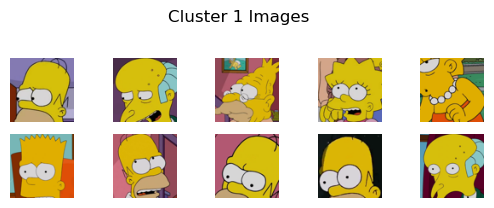

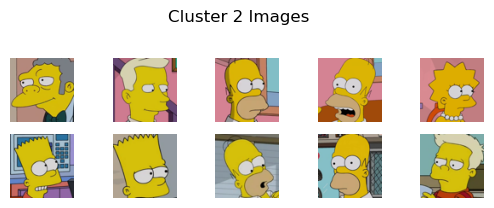

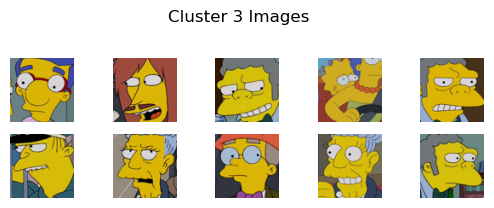

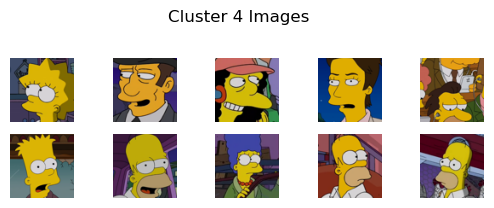

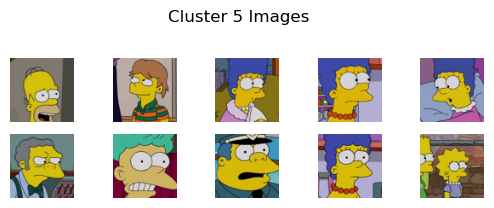

In [106]:
for cluster_idx in range(n_clusters):
    plot_images_from_cluster(cluster_idx, simpsons_rgb, clusters)


In [107]:
def plot_representative_images_from_cluster(cluster_idx, images, labels, n_representative, target_size):
    
    cluster_indices = np.where(labels == cluster_idx)[0]

    representative_indices = np.random.choice(cluster_indices, n_representative, replace=False)

    plt.figure()
    for i, idx in enumerate(representative_indices):
        ax = plt.subplot(1, n_representative, i + 1) 

        image = images[idx].reshape(target_size[0], target_size[1], 3)
        ax.imshow(image)
        ax.axis('off')

    plt.suptitle(f"Cluster {cluster_idx + 1}: Representative Images")
    plt.show()

def plot_all_clusters(images, labels, n_clusters, n_representative=3, target_size=(75, 75)):
    for cluster_idx in range(n_clusters):
        plot_representative_images_from_cluster(cluster_idx, images, labels, n_representative, target_size)


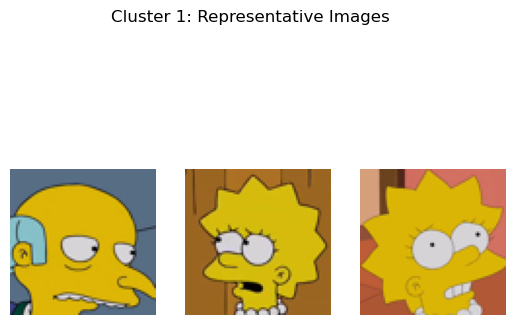

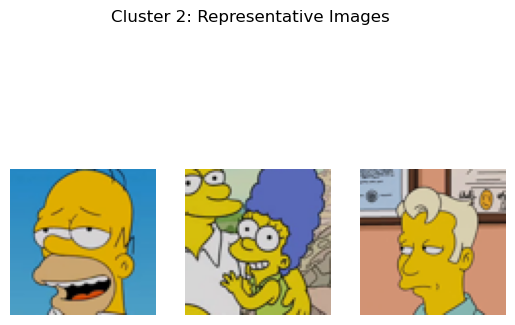

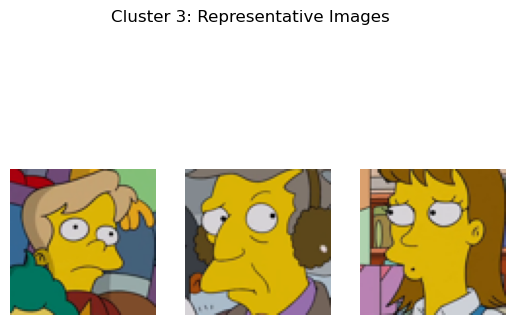

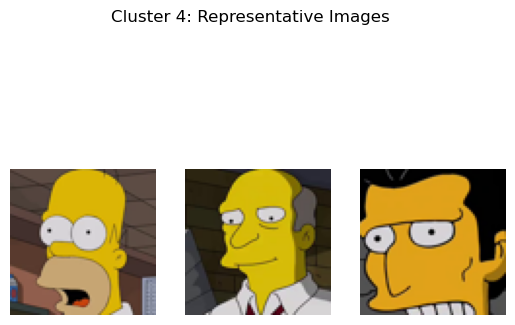

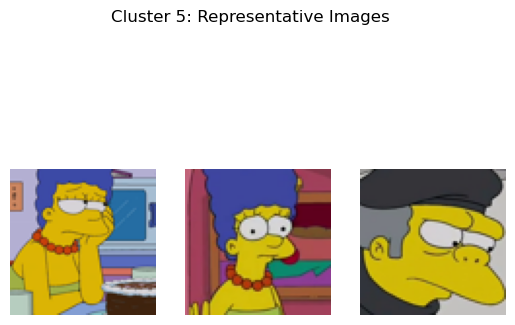

In [108]:
plot_all_clusters(simpsons_rgb, clusters, n_clusters=5, n_representative=3, target_size=(75, 75))


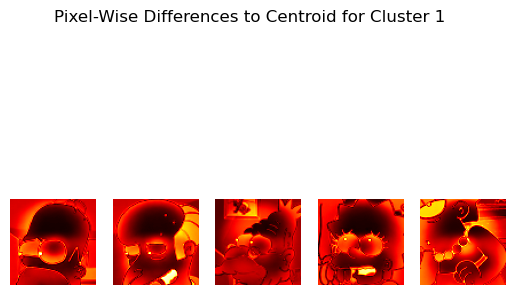

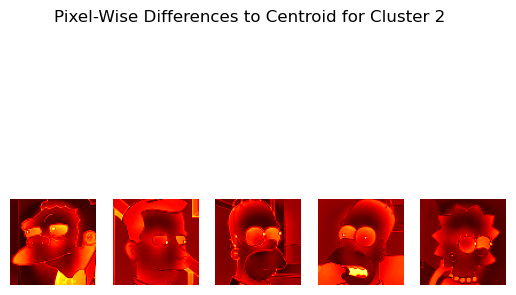

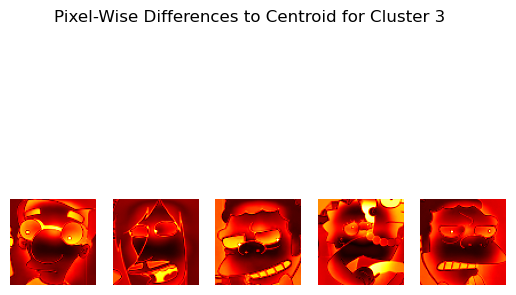

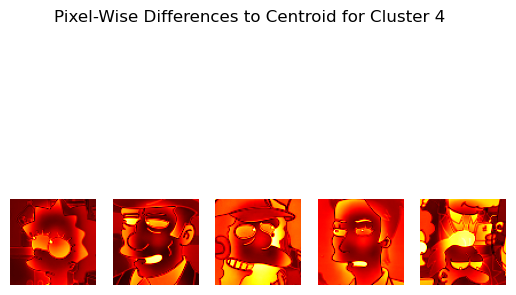

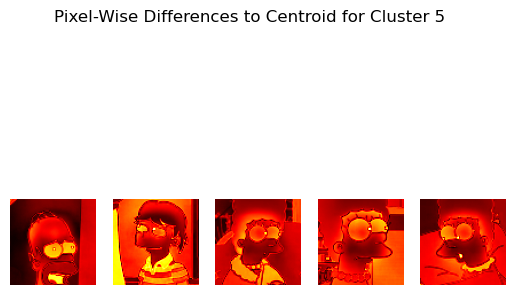

In [109]:
def plot_pixelwise_distances(cluster_idx, images, labels, target_size):
    
    cluster_indices = np.where(labels == cluster_idx)[0]
    cluster_images = images[cluster_indices]
    cluster_images = cluster_images.reshape((cluster_images.shape[0], target_size[0], target_size[1], 3))
    cluster_centroid = np.mean(cluster_images, axis=0)

    num_images_to_plot = 5
    plt.figure()

    for i in range(min(num_images_to_plot, len(cluster_images))):
        ax = plt.subplot(1, num_images_to_plot, i + 1)

        pixelwise_diff = np.abs(cluster_images[i] - cluster_centroid)  
        diff_norm = np.linalg.norm(pixelwise_diff, axis=-1)  
        ax.imshow(diff_norm, cmap='hot')  
        ax.axis('off')

    plt.suptitle(f"Pixel-Wise Differences to Centroid for Cluster {cluster_idx + 1}")
    plt.show()


plot_pixelwise_distances(0, simpsons_rgb, clusters, target_size=(75, 75))
plot_pixelwise_distances(1, simpsons_rgb, clusters, target_size=(75, 75))
plot_pixelwise_distances(2, simpsons_rgb, clusters, target_size=(75, 75))
plot_pixelwise_distances(3, simpsons_rgb, clusters, target_size=(75, 75))
plot_pixelwise_distances(4, simpsons_rgb, clusters, target_size=(75, 75))



### (Likely delete everything below until b & w code, since that code for color pca was INCORRECT)

In [5]:
test_img = Image.open('simpsons_faces_kostastokis/cropped/437.png').convert('RGB').resize((75, 75))
print(np.array(test_img).shape)

(75, 75, 3)


In [21]:
def viewcolumn(columnvector):
    # viewcolumn(columnvector);
    # VIEWCOLUMN Displays a 75 x 85 rgb image stored in a column vector.
    # Tim Marks 2002
    plt.imshow(columnvector.reshape((75, 75, 3), order='F').astype('uint8'))
    plt.title("Color Image")
    plt.axis('off')
    plt.show()
    

def normc(Mat):
    # normc(M) normalizes the columns of M to a length of 1.
    return normalize(Mat, norm='l2', axis=0)

Compute & Display Mean Face:

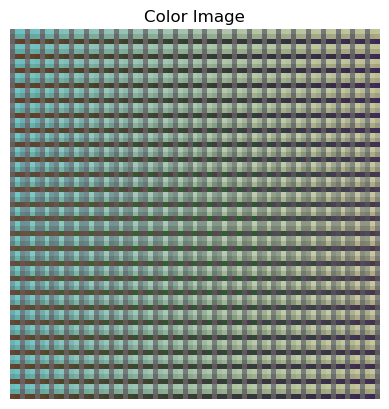

In [22]:
# find mean
mean_simp_rgb = np.mean(simpsons_rgb, axis=0)

# View a transformed version of mean

# since we are using RGB, there are 3 color channels, thus 75 x 75 x 3
mean_simp_view = mean_simp_rgb.reshape((75, 75, 3), order="F")
viewcolumn(mean_simp_view)

**PCA method #1**: Directly compute ATA and its eigenvectors

In [ ]:
# A = simpsons_df - mean_simp
    # Find eigenvectors & eigenvalues of ATA
# eigvals, V_old =np.linalg.eig(A.T.dot(A))
    # Sort the eigenvectors & eigenvalues from largest to smallest
# V, D = eigsort(V_old, eigvals)
    # calcualte the matrix of eigensimpsons, (the eigenvectors of AAT)
# U = A.dot(V)

    # normalize the columns of U (should all have length 1)
# U = normc(U)

In [ ]:
# Check that A, U, V, & D are looking as expected

# assert A.shape == 
# assert V.shape == 
# assert U.shape ... 
# check D, that diagonal matrix of eigenvalues are sorted from largest to smallest


In [ ]:
# function to reconstruct desired simpson image

#def reconstruct_simp(i):
        # find pricipal compoents of image
    #princ_comp = simpsons_rgb[i, :] - mean_simp
    #c = U.T.dot(princ_comp)
        # reconstruct face using all principal components
    #Zhat = U.dot(c) + mean_simp
        # reconstruct using just first 10 principal components
    #Zhat_2 = U[:,:10].dot(c[:10,]) + mean_simp

    #viewcolumn(Zhat.reshape((100,100), order='F'))
    #viewcolumn(Zhat_2.reshape((100,100), order='F'))


I wrote the above code based on the code for HW4, but I think for our large dataset, as it was taking over an hour to run, and I did not even get to finish running it. We will need something more efficient, and something that only uses the most efficient/important principal components. Thus, maybe we discuss our understanding of above code, but ultimately have have to use a different method. 

**PCA method #2**: Singular Value Decomposition

In [8]:
A = simpsons_rgb - mean_simp_rgb

# Use SVD tp represent reduced-dimension subspace using following components:
    # U = left eigenvectors, 
    # S = sqrt of eigenvalues/diagonal values, 
    # Vt = transposed right singular vectors 
U, S, Vt = np.linalg.svd(A, full_matrices=False)

# Specify to keep only 50 top princial components that contribute most variation
k = 50
# top 50 eigensimpsons
Uk = U[:, :k]
Sk = S[:k]
Vtk = Vt[:k, :]

# get the reduced representation
Z = A.dot(Vtk.T)


In [9]:
# code for reconstruction

def reconstruct_simp_2(Z, i, Vtk, mean_simp_rgb):
    reconstructed_simp = Z[i, :].dot(Vtk) + mean_simp_rgb
    return reconstructed_simp

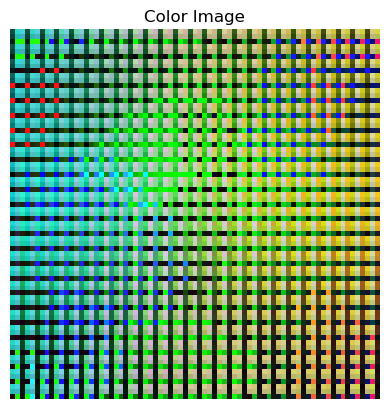

In [10]:
# test and vizualize reconstructionl

reconstruct_first = reconstruct_simp_2(Z, 0, Vtk, mean_simp_rgb)
reconstruct_first_view = reconstruct_first.reshape((75, 75, 3), order="F")
viewcolumn(reconstruct_first_view)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


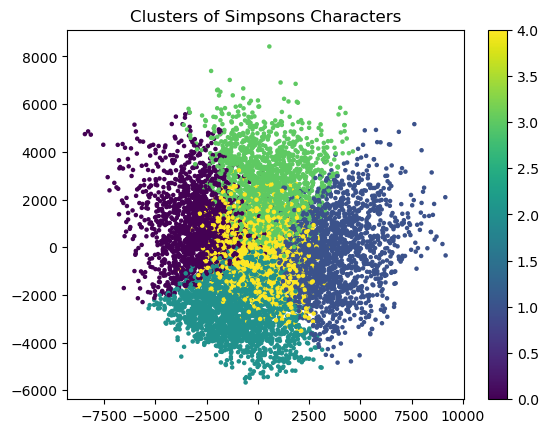

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=42)  
labels = kmeans.fit_predict(Z)

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z)

plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Clusters of Simpsons Characters")
plt.colorbar()
plt.show()

In [12]:
cluster_labels = kmeans.labels_

clustered_data = pd.DataFrame(Z, columns=[f"PC{i+1}" for i in range(Z.shape[1])])
clustered_data['Cluster'] = cluster_labels

cluster_means = clustered_data.groupby('Cluster').mean()

print(cluster_means.iloc[:, :5]) 

                 PC1          PC2          PC3         PC4         PC5
Cluster                                                               
0       -2843.558644  -925.070578  -267.818235 -757.599196  -69.878066
1        3625.189279   206.876094  -325.681502 -488.273403  -28.185681
2        -949.813630  2436.073085  -747.818804   63.628604  103.522771
3         355.763305 -2478.200823  -649.723676  697.511011   47.917648
4         -20.235349   300.227841  2051.552191  454.270207  -69.951011


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


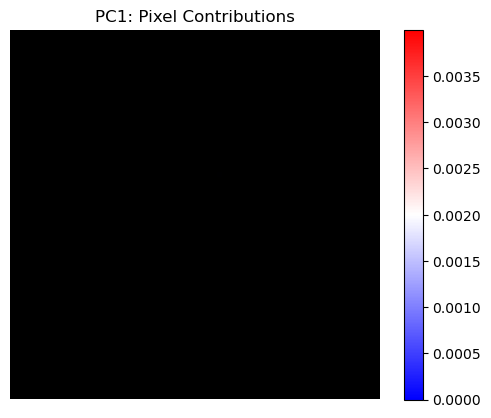

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


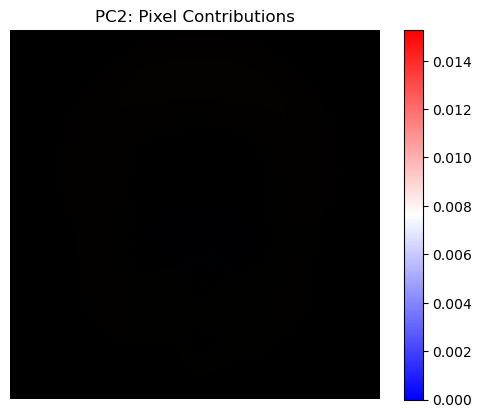

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


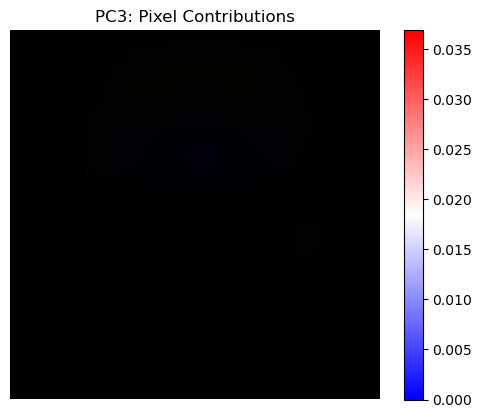

In [16]:
num_pcs_to_inspect = 3

for i in range(num_pcs_to_inspect):
    component = Vtk[i, :].reshape(75, 75, 3)  
    plt.imshow(component, cmap='bwr')
    plt.title(f"PC{i+1}: Pixel Contributions")
    plt.colorbar()
    plt.axis('off')
    plt.show()

Cluster 0:


ValueError: 'RGB' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

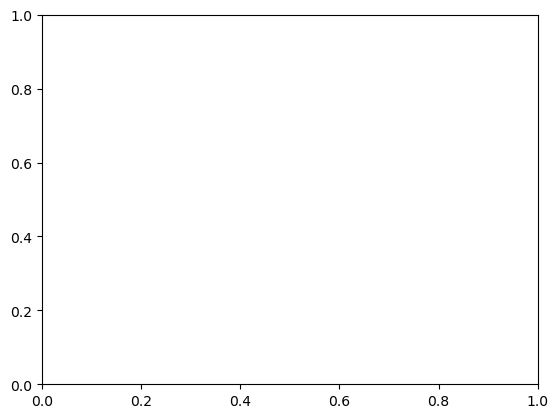

In [19]:
def find_representative_images(Z, cluster_labels, n_representatives=2):
    representatives = {}
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_points = Z[cluster_indices]
        cluster_center = cluster_points.mean(axis=0)
        distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
        representative_indices = cluster_indices[np.argsort(distances)[:n_representatives]]
        representatives[cluster] = representative_indices
    return representatives

representative_images = find_representative_images(Z, cluster_labels)

for cluster, indices in representative_images.items():
    print(f"Cluster {cluster}:")
    for idx in indices:
        reconstructed = reconstruct_simp_2(Z, idx, Vtk, mean_simp_rgb)
        plt.imshow(reconstructed.reshape(75, 75, 3), cmap='RGB')
        plt.title(f"Cluster {cluster}, Image {idx}")
        plt.axis('off')
        plt.show()

# Black & White Version w/ Re-loaded data

In [26]:
# import dataset

# import additional packages to process images as dataset
import os
from PIL import Image

# wrangle images and transform into arrays
def load_images_from_folder(folder_path, target_size=(200, 200)):
    images = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Load image
            img = Image.open(file_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to target size
            images.append(np.array(img).flatten())  # Flatten to 1D array
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images)

# Load dataset
folder_path = "simpsons_faces_kostastokis/cropped"
simpsons_df = load_images_from_folder(folder_path, target_size=(75,75))

# Check the shape of the dataset
print(f"Dataset shape: {simpsons_df.shape}")



Dataset shape: (9877, 5625)


In [ ]:
def viewcolumn(columnvector, image_size=(50, 50, 2), title="Image"):
    columnvector = columnvector.reshape(image_size)
    plt.imshow(columnvector, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    

def normc(Mat):
    # normc(M) normalizes the columns of M to a length of 1.
    return normalize(Mat, norm='l2', axis=0)

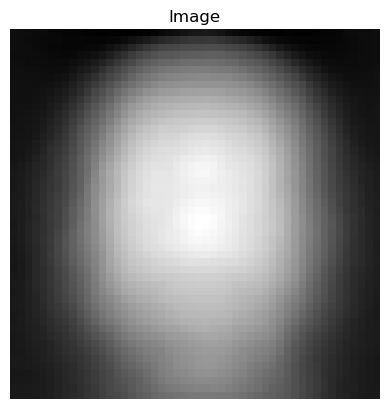

In [ ]:
# find mean
mean_simp = np.mean(simpsons_df, axis=0)

# View a transformed version of mean

mean_simp_view = mean_simp.reshape((50, 50))
viewcolumn(mean_simp_view)

As we can observe from the mean simpsons face, this visualization doesn’t clearly show specific facial features like eyes, nose, or mouth. Instead, it provides a general pattern, with a bright center that likely corresponds to areas of high pixel intensity overlap, such as the central region of the faces. The lack of distinct features could be due to significant simpsons' variation in the dataset (e.g., different expressions, angles, or noise). This graph seems more like a blurred intensity map rather than a detailed mean face.

In [14]:
A = simpsons_df - mean_simp

# Use SVD tp represent reduced-dimension subspace using following components:
    # U = left eigenvectors, 
    # S = sqrt of eigenvalues/diagonal values, 
    # Vt = transposed right singular vectors 
U, S, Vt = np.linalg.svd(A, full_matrices=False)

# Specify to keep only 50 top princial components that contribute most variation
k = 50
# top 50 eigensimpsons
Uk = U[:, :k]
Sk = S[:k]
Vtk = Vt[:k, :]

# get the reduced representation
Z = A.dot(Vtk.T)


In [15]:
# code for reconstruction

def reconstruct_simp_2(Z, i, Vtk, mean_simp):
    reconstructed_simp = Z[i, :].dot(Vtk) + mean_simp
    return reconstructed_simp

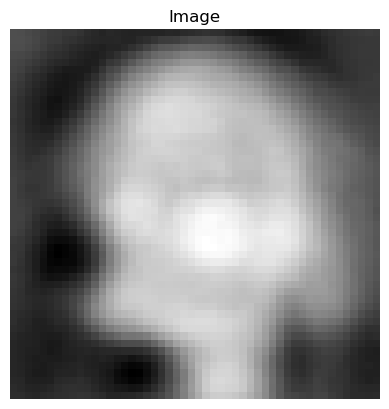

In [16]:
reconstruct_first = reconstruct_simp_2(Z, 0, Vtk, mean_simp)

reconstruct_first_view = reconstruct_first.reshape((50, 50))
viewcolumn(reconstruct_first_view)

This reconstructed image is blurry and lacks clear details, but it roughly captures the structure of a face. The bright center might represent areas like the eyes or forehead, while darker regions could be the background. The lack of clarity suggests that the reconstruction used very few components, or the dataset has a lot of variation. Adding more components or improving preprocessing could help make the features more distinct. Thus, instead of PCA, we might also consider trying other clustering methods to see which weather fits the dataset better.

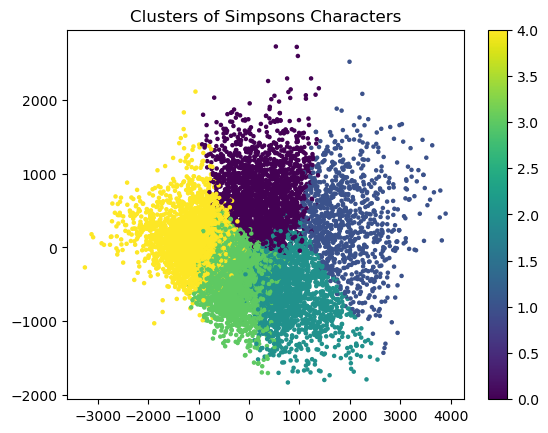

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=42)  
labels = kmeans.fit_predict(Z)

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z)

plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Clusters of Simpsons Characters")
plt.colorbar()
plt.show()


This scatter plot shows how Simpson characters group together after reducing the data to two dimensions using PCA. We can see clear clusters, which likely reflect similarities in the characters' traits or features. While most groups are well-separated, there’s some overlap in the middle, meaning a few characters share similar characteristics. The color gradient adds another layer of information, possibly related to the character labels or other variables. Overall, this plot does a good job of showing how the characters relate to each other in a simpler, more visual way.

Then, we perform clustering using KMeans, assigning each data point to a cluster, and then calculating and displaying the average values of the first five principal components for each cluster.

In [40]:
cluster_labels = kmeans.labels_

clustered_data = pd.DataFrame(Z, columns=[f"PC{i+1}" for i in range(Z.shape[1])])
clustered_data['Cluster'] = cluster_labels

cluster_means = clustered_data.groupby('Cluster').mean()

print(cluster_means.iloc[:, :5]) 


                 PC1         PC2         PC3         PC4        PC5
Cluster                                                            
0        -258.837292  708.452425   34.528596 -121.569409  83.035543
1       -1923.790275  351.995548   -4.465727   87.846669 -88.581490
2        -830.657446 -591.560305 -114.282904  147.372604 -49.962159
3         287.725692 -400.098137  148.594225 -174.907630  64.727496
4        1148.219315  101.593952  -95.931030  138.283180 -63.929879


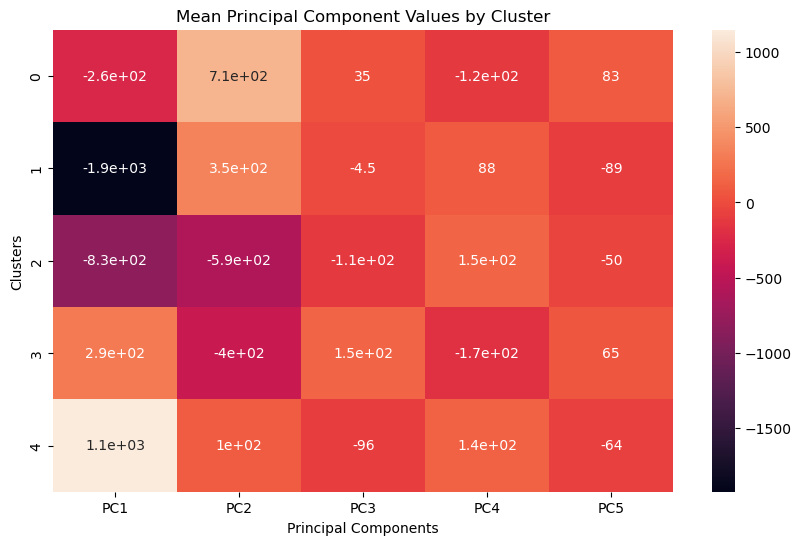

In [41]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.iloc[:, :5], annot=True)
plt.title("Mean Principal Component Values by Cluster")
plt.xlabel("Principal Components")
plt.ylabel("Clusters")
plt.show()


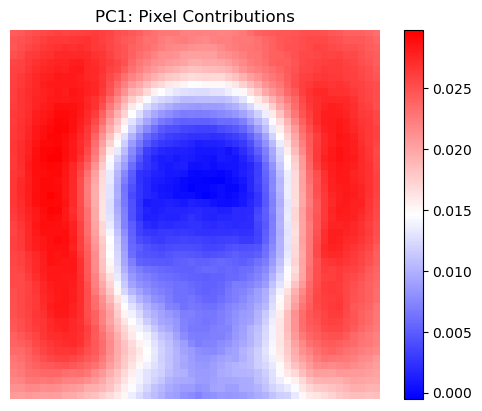

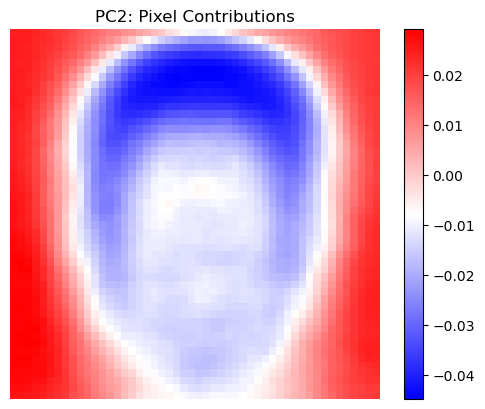

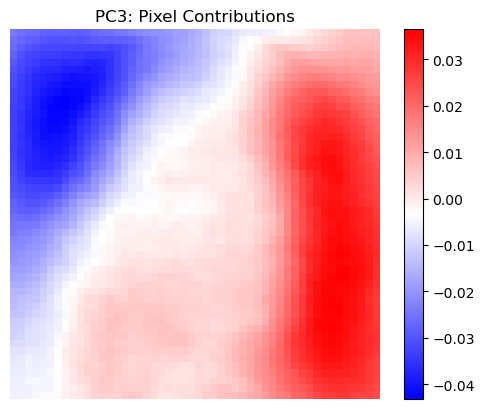

In [39]:
num_pcs_to_inspect = 3

for i in range(num_pcs_to_inspect):
    component = Vtk[i, :].reshape(50, 50)  
    plt.imshow(component, cmap='bwr')
    plt.title(f"PC{i+1}: Pixel Contributions")
    plt.colorbar()
    plt.axis('off')
    plt.show()


Cluster 0:


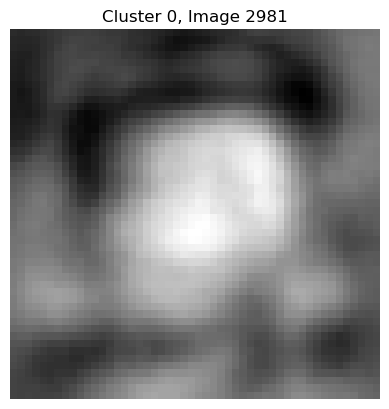

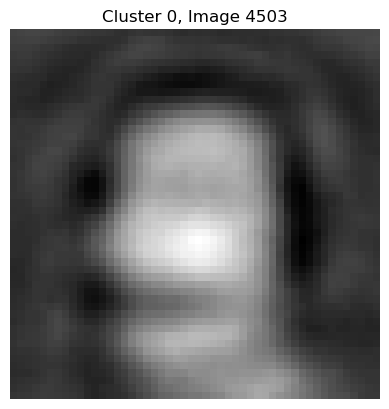

Cluster 1:


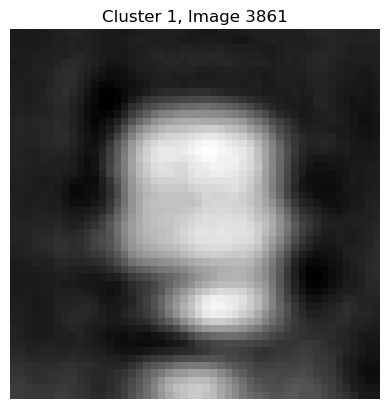

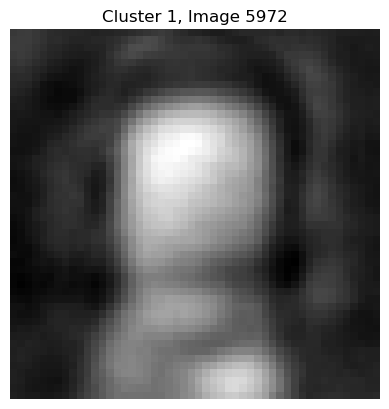

Cluster 2:


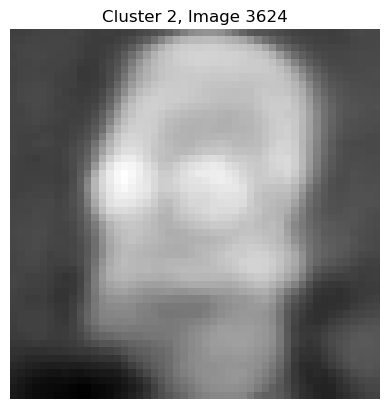

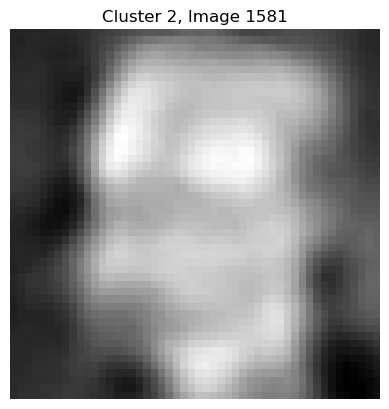

Cluster 3:


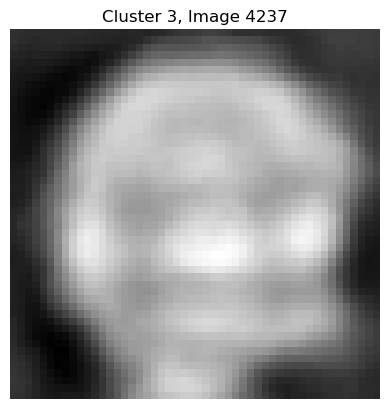

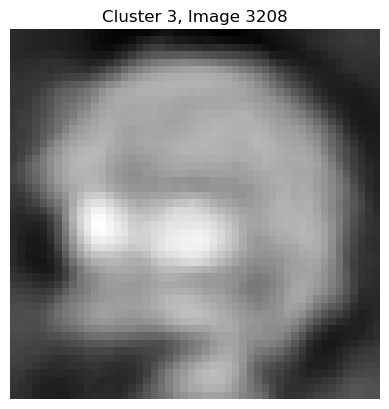

Cluster 4:


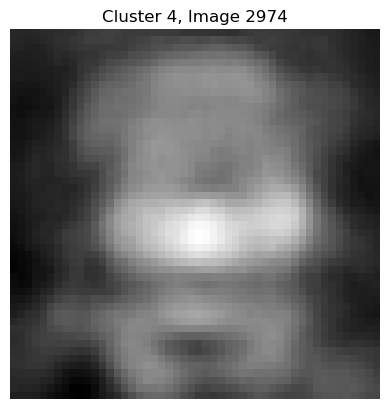

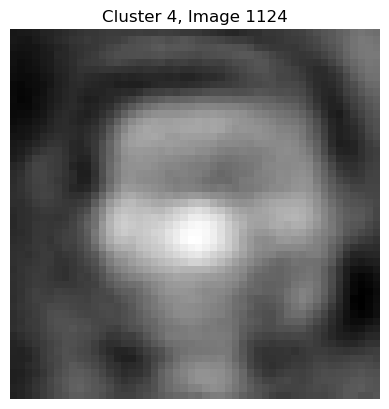

In [43]:
def find_representative_images(Z, cluster_labels, n_representatives=2):
    representatives = {}
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_points = Z[cluster_indices]
        cluster_center = cluster_points.mean(axis=0)
        distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
        representative_indices = cluster_indices[np.argsort(distances)[:n_representatives]]
        representatives[cluster] = representative_indices
    return representatives

representative_images = find_representative_images(Z, cluster_labels)

for cluster, indices in representative_images.items():
    print(f"Cluster {cluster}:")
    for idx in indices:
        reconstructed = reconstruct_simp_2(Z, idx, Vtk, mean_simp)
        plt.imshow(reconstructed.reshape(50, 50), cmap='gray')
        plt.title(f"Cluster {cluster}, Image {idx}")
        plt.axis('off')
        plt.show()


This code identifies and displays the most representative images for each cluster based on their proximity to the cluster center in the reduced feature space. It selects the closest n images from each cluster, reconstructs them, and then visualizes these representative images with titles indicating their cluster and index. We can observe from the graph that some of the clusters have distinct characteristics such as beards, hairstyles, eye positions, etc.

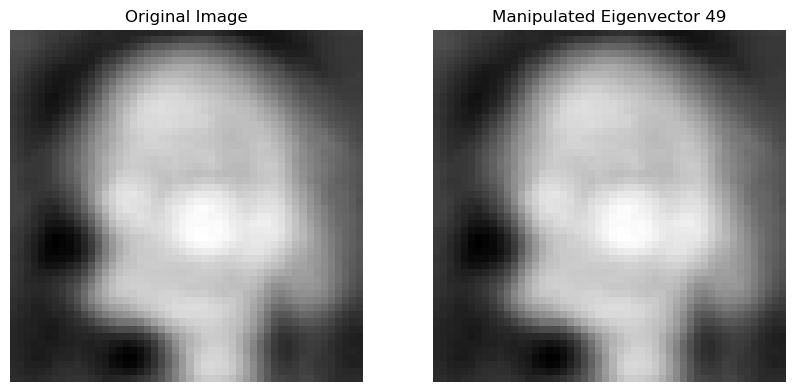

In [64]:
import matplotlib.pyplot as plt

def manipulate_eigenvector(i, factor, Vtk, mean_simp, Z, image_index=0):
    manipulated_Z = Z.copy()
    manipulated_Z[image_index, i] += factor
    
    original_image = Z[image_index, :] @ Vtk + mean_simp
    manipulated_image = manipulated_Z[image_index, :] @ Vtk + mean_simp
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
    axes[0].imshow(original_image.reshape((50, 50)), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(manipulated_image.reshape((50, 50)), cmap='gray')
    axes[1].set_title(f"Manipulated Eigenvector {i}")
    axes[1].axis('off')
    
    plt.show()

manipulate_eigenvector(49, factor=1, Vtk=Vtk, mean_simp=mean_simp, Z=Z)


This code manipulates a specific eigenvector of an image by adjusting its value and then displays both the original and manipulated images side by side. It allows us to see how changing a principal component affects the image's appearance. As to the output result, the manipulated eigenvector 49 didn't change very much, but we observed the image is more detailed and higher contrast in colors.

Code to perform reproduction:

**Test: Reconstruct each PCA model, then measure distance between reconstruction and input**

**Find & Discuss Lowest Distance**